<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Applying Transformers for Classification**

Estimated time needed: **60** minutes

Imagine working at a prestigious newspaper or magazine company that boasts an extensive archive of documents dating back through the annals of time. Amid this treasure trove of information, a monumental task lies ahead: organizing these historical documents into their relevant topic sections. This strategic curation not only promises to enhance the user experience by delivering more streamlined content but also presents an opportunity to breathe new life into invaluable insights from the past through a modern lens. However, the sheer volume and scope of this undertaking calls for a sophisticated solution.

![Documents Overload](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0Y15EN/docs.png)

The implementation of an automated machine learning system makes it very efficient. Such a system, equipped with advanced natural language processing and machine learning capabilities, could sift through the vast archives, categorizing articles into their respective topics with remarkable precision. As a result, readers would seamlessly access a wealth of knowledge tailored to their interests, while the editorial team gains newfound agility in content management.

In this lab, you will embark on the exciting task of classifying news articles for a content search engine. The goal is to build a model that can automatically categorize news articles into different topics or classes, enabling the search engine to deliver relevant content to users efficiently. To achieve this, you will leverage the powerful torchtext library, which simplifies the process of creating a dataset for text classification analysis.

With torchtext, you'll have the flexibility to access and preprocess raw news data effortlessly. The library enables you to convert text strings into torch.Tensors, which are essential for training machine learning models. By using torchtext's convenient functionalities, you can set up an efficient data processing pipeline that prepares your text data for classification.

Throughout this tutorial, you will demonstrate how to effectively shuffle and iterate through the processed data using torch.utils.data.DataLoader. This DataLoader simplifies the data handling process, allowing you to focus on building and training your text classification model effectively.



The following infographic provides an overview of the internal workings of the transformers.
![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/Tokenization%20-%20Color.jpeg)


# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
            <li><a href="#Defining-helper-hunctions">Defining helper functions</a></li>
        </ol>
    </li>
    <li><a href="#Toy-dataset">Toy dataset</a>
    <li><a href="#Zero-padding">Zero padding</a></li>
    <li><a href="#Positional-encodings">Positional encodings</a></li>
    <li><a href="#Encoder-layer">Encoder layer</a></li>
    <li>
        <a href="#Text-classification">Text classification</a></li>
        <ol>
            <li><a href="#Import-bank-dataset">Import bank dataset</a></li>
            <li><a href="#Dataset">Dataset</a></li>
            <li><a href="#Data-loader">Data loader</a></li>
            <li><a href="#Neural-network">Neural network</a></li>
        </ol>
    <li><a href="#Training">Training</a></li>
    <li><a href="#Exercise">Exercise</a></li>
</ol>


---


# Objectives

After completing this lab, you will be able to:

- Work with datasets and understand tokenizer, embedding bag technique and vocabulary
- Explore embeddings in PyTorch and understand token indices
- Perform text classification using data loader and apply it on a neural network model
- Train the text classification model on a news dataset
- Engage in various exercises to solidify your understanding


---


# Setup


For this lab, you will be using the following libraries:


### Installing required libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!pip` in the code cell below.


In [1]:
# All Libraries required for this lab are listed below. 
# The libraries pre-installed on Skills Network Labs are commented. 
# Uncomment these if you are running the lab in your localenvironment, to install these packages.

# !pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# - Update a specific package
# !pip install pmdarima -U
# - Update a package to specific version
# !pip install --upgrade pmdarima==2.0.2
# Note: If your environment doesn't support "!pip install", use "!mamba install"

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [2]:
!pip install dash-core-components==2.0.0 
!pip install dash-table==5.0.0
!pip install dash==2.9.3
!pip install -Uqq dash-html-components==2.0.0
!pip install -Uqq portalocker>=2.0.0
!pip install -qq torchtext
!pip install -qq torchdata
!pip install -Uqq plotly

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.9.3 requires dash-html-components==2.0.0, which is not installed.
dash 2.9.3 requires dash-table==5.0.0, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.9.3 requires dash-html-components==2.0.0, which is not installed.


### Importing required libraries


In [3]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import pickle

from torch.nn.utils.rnn import pad_sequence

### Defining helper functions


In [4]:
def plot(COST,ACC):
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [5]:
def plot_embdings(my_embdings,name,vocab):
  
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [6]:


def plot_tras(words, model):
    # Tokenize the input words using a tokenizer function
    tokens = tokenizer(words)

    # Define the model's embedding dimension (d_model)
    d_model = 100

    # Convert the input words to a PyTorch tensor and move it to the specified device
    x = torch.tensor(text_pipeline(words)).unsqueeze(0).to(device)

    # Apply the model's embedding layer and scale the embeddings by sqrt(d_model)
    x_ = model.emb(x) * math.sqrt(d_model)

    # Apply the model's positional encoder to the embeddings
    x = model.pos_encoder(x_)

    # Extract projection weights for query, key, and value from the model's state_dict
    q_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][0:embed_dim].t()
    k_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
    v_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

    # Calculate query (Q), key (K), and value (V) matrices
    Q = (x @ q_proj_weight).squeeze(0)
    K = (x @ k_proj_weight).squeeze(0)
    V = (x @ v_proj_weight).squeeze(0)

    # Calculate attention scores using dot-product attention
    scores = Q @ K.T

    # Set row and column labels for the attention matrix
    row_labels = tokens
    col_labels = row_labels

    # Create a heatmap of the attention scores
    plt.figure(figsize=(10, 8))
    plt.imshow(scores.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Dot-Product Attention")
    plt.show()

    # Apply softmax to the attention scores and create a heatmap
    att = nn.Softmax(dim=1)(scores)
    plt.figure(figsize=(10, 8))
    plt.imshow(att.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Scaled Dot-Product Attention")
    plt.show()

    # Calculate the attention head by multiplying softmax scores with values (V)
    head = nn.Softmax(dim=1)(scores) @ V

    # Visualize the embeddings and attention heads using t-SNE
    tsne(x_, tokens, title="Embeddings")
    tsne(head, tokens, title="Attention Heads")


def tsne(embeddings, tokens, title="Embeddings"):
    # Initialize t-SNE with 2 components and a fixed random state
    tsne = TSNE(n_components=2, random_state=0)

    # Fit t-SNE to the embeddings (converting from GPU if necessary)
    tsne_result = tsne.fit_transform(embeddings.squeeze(0).cpu().detach().numpy())

    # Create a scatter plot of the t-SNE results
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

    # Set a title for the plot
    plt.title(title)

    # Add labels for each point in the scatter plot
    for j, label in enumerate(tokens):
        # Place the label text at the corresponding t-SNE coordinates
        plt.text(tsne_result[j, 0], tsne_result[j, 1], label)

    plt.show()

In [7]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

## Toy dataset
These are essentially the same steps that you have done in the previous labs. However, let's have a brief explanation. The code defines a dataset, tokenizes the text data using a basic English tokenizer, creates a vocabulary from the tokenized data, and sets up a default index for handling unknown tokens.


In [8]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.

The function **```text_pipeline```** will tokenize the input text, and **```vocab```** will then be applied to get the token indices.
The **```label_pipeline```** will ensure that the labels start at zero.

These pipelines are defined here for future use.


In [9]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1


## Zero padding
In numerous PyTorch applications, ensuring consistent batch sizes is a fundamental requirement. This necessitates the use of zero-padding to harmonize varying sequence lengths within each batch, you can do this using ```pad_sequence```, consider the list of tensors of different lengths:


In [10]:
sequences = [torch.tensor([j for j in range(1,i)]) for i in range(2,10)]
sequences

[tensor([1]),
 tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8])]

The function `pad_sequence` from `torch.nn.utils.rnn` in PyTorch is used to pad a sequence of tensors to the same length along a specified dimension. This function is commonly used when dealing with sequences of variable lengths, such as in natural language processing (NLP) tasks when working with tokenized sentences of different lengths.

Here's how it works:

1. **Input**: `pad_sequence` takes a list of tensors as input, where each tensor represents a sequence. These sequences can have different lengths.
2. **Padding**: The function pads the sequences with zeros (or another specified padding value) to make them all the same length. It pads sequences to match the length of the longest sequence in the list.
3. **Output**: The output is a single tensor where all sequences are stacked along the specified dimension (by default, it's the first dimension). The result is a batch of sequences with the same length.


In [11]:
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
print(padded_sequences)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0],
        [1, 2, 3, 0, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])


---


## Positional encodings

Positional encodings play a pivotal role in transformers and various sequence-to-sequence models, aiding in conveying critical information regarding the positions or sequencing of elements within a given sequence. To illustrate, let's examine the sentences: "He painted the car red" and "He painted the red car." Despite their distinct meanings, it's worth noting that the embeddings for these sentences remain identical as shown here:


In [12]:
my_tokens='he painted the car red he painted the red car'

my_index=text_pipeline(my_tokens)
my_index

embedding_dim=3

vocab_size=len(vocab)
print(vocab_size)

embedding = nn.Embedding(vocab_size, embedding_dim)

27


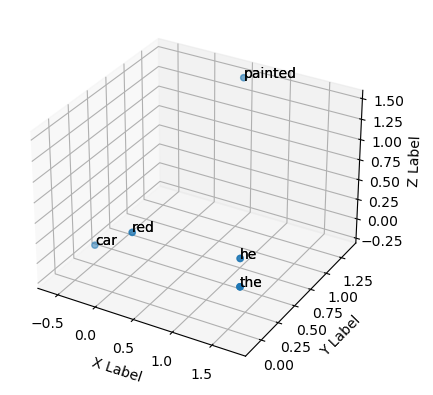

In [13]:
my_embdings=embedding(torch.tensor(my_index)).detach().numpy()
plot_embdings(my_embdings,tokenizer(my_tokens),vocab)

You can effectively represent the position of each sample within a sequence by associating it with its corresponding position index, expressing the positional encoding as $p_{n}=n$, where $n$ represents the sample's position in the sequence. To illustrate, you can assign index 0 to the initial encoding, index 1 to the second, and so forth. This approach remains robust even when handling sequences of considerable length, extending as far as your vocabulary permits.


In [14]:
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
position

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.]])

You can assign importance to each dimension \(d\) within the embedding, denoting it as $\textbf{p}_{n,d}$. For instance, in the case of an embedding dimension of three, the positional encodings $\textbf{p}_{n,d}$ would be represented as $[\text{ }p_{n,1},\text{ }p_{n,2},\text{ }p_{n,3}]$, which, in turn, corresponds to a three-dimensional embedding of each token.


In [15]:
d_model=3
pe = torch.zeros(vocab_size,d_model )

In [16]:
pe=torch.cat((position, position, position), 1)
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

You only need positional encodings for each sequence of embeddings, and to determine this, simply count the number of embeddings in the sequence.


In [17]:
samples,dim=my_embdings.shape
samples,dim

(10, 3)

Once you add the positional encodings to the embeddings and plot the results; you will observe that they are different.


In [18]:
pos_embding=my_embdings+pe[0:samples,:].numpy()

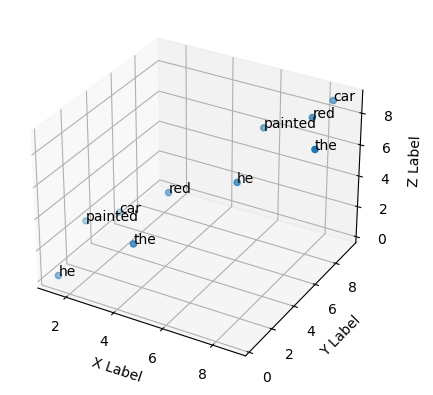

In [19]:
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

An issue arising from the integration of linear positional encodings lies in the substantial increase in the magnitude of embeddings for positions further along in the sequence. This phenomenon becomes particularly pronounced when dealing with extensive sequences. For instance, when examining the embeddings for the word "car" at indices 3 and 9, you will observe that the embedding at position 9 is notably larger. This disparity intensifies as the sequence length grows. Given that embeddings are meant to represent words, aim to avoid excessive divergence from the original embeddings.


In [20]:
pos_embding[3]# add -3 to get original embedding

array([2.4004536, 3.3723984, 2.8087606], dtype=float32)

In [21]:
pos_embding[-1]#add -9 original embedding

array([8.400454, 9.372398, 8.808761], dtype=float32)

You can address this magnitude issue through various approaches. Firstly, you can employ a function that doesn't exhibit such significant amplification. Additionally, you have the option to introduce different functions. For instance, when considering your word positional encodings, the magnitude of the positional encodings $\textbf{p}_{n,d}$ can be represented as $[p_{n,1}, p_{n,2}, p_{n,3}]$, which, in this case, translates to $[0.1n, -0.1n, 1]$.


In [22]:
pe=torch.cat((0.1*position, -0.1*position, 0*position), 1)

You can plot the positional encodings.


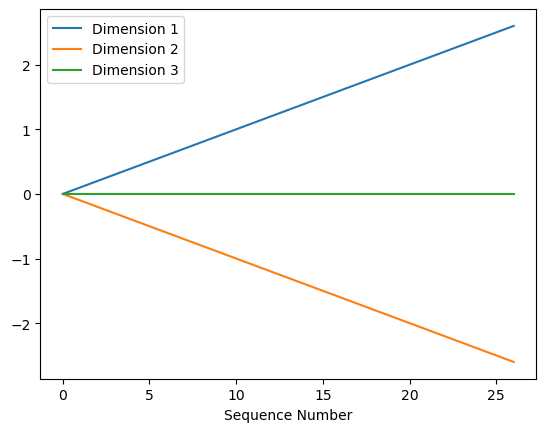

In [23]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

You will observe that the words are closer together, but employing a linear function still presents the same drawbacks.


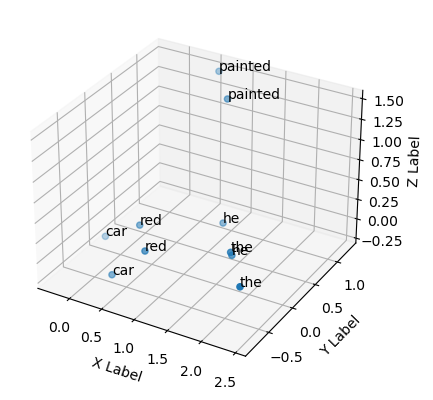

In [24]:
pos_embding=my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

When you examine the positional encodings, you will notice that the words appear to be closer together. However, it's important to acknowledge that the use of a linear function introduces similar drawbacks. While the words may seem closer in proximity, you will still encounter certain limitations associated with linear positional encodings. These limitations include the potential for amplifying magnitudes, which can impact the model's ability to effectively capture nuanced positional information. To address these challenges, alternative approaches and functions can be explored to provide more context-aware and adaptive positional encodings.

Periodic functions, such as sine and cosine functions, possess the property of periodicity. This means they repeat their values over a regular interval, preventing them from growing too rapidly.


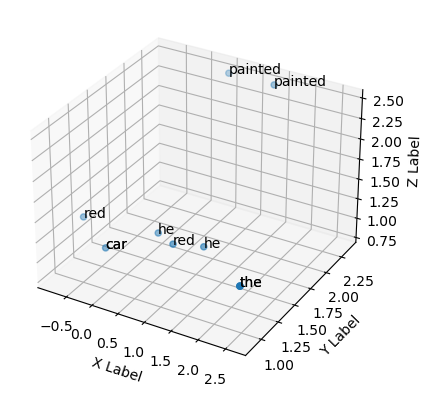

In [25]:
pe=torch.cat((torch.sin(2*3.14*position/6), 0*position+1, 0*position+1), 1)
pos_embding=my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

The first dimension of **$pe$** follows a sine wave pattern, while the 2nd and 3rd dimensions have constant values. This is showcased in the graph below.


In [26]:
pe

tensor([[ 0.0000,  1.0000,  1.0000],
        [ 0.8658,  1.0000,  1.0000],
        [ 0.8666,  1.0000,  1.0000],
        [ 0.0016,  1.0000,  1.0000],
        [-0.8650,  1.0000,  1.0000],
        [-0.8673,  1.0000,  1.0000],
        [-0.0032,  1.0000,  1.0000],
        [ 0.8642,  1.0000,  1.0000],
        [ 0.8681,  1.0000,  1.0000],
        [ 0.0048,  1.0000,  1.0000],
        [-0.8634,  1.0000,  1.0000],
        [-0.8689,  1.0000,  1.0000],
        [-0.0064,  1.0000,  1.0000],
        [ 0.8626,  1.0000,  1.0000],
        [ 0.8697,  1.0000,  1.0000],
        [ 0.0080,  1.0000,  1.0000],
        [-0.8617,  1.0000,  1.0000],
        [-0.8705,  1.0000,  1.0000],
        [-0.0096,  1.0000,  1.0000],
        [ 0.8609,  1.0000,  1.0000],
        [ 0.8713,  1.0000,  1.0000],
        [ 0.0111,  1.0000,  1.0000],
        [-0.8601,  1.0000,  1.0000],
        [-0.8721,  1.0000,  1.0000],
        [-0.0127,  1.0000,  1.0000],
        [ 0.8593,  1.0000,  1.0000],
        [ 0.8728,  1.0000,  1.0000]])

You have observed an intriguing characteristic in the word embeddings: they are positioned closely enough to maintain proximity while remaining sufficiently distinct from each other. However, there is a notable exception when it comes to the embedding for "car." This anomaly arises because the sine wave used in positional encoding is inherently periodic, as illustrated in the image below, where you can observe the repetitive nature of the sine function. Consequently, the positional encoding for "car" at different locations within the sequence remains the same.


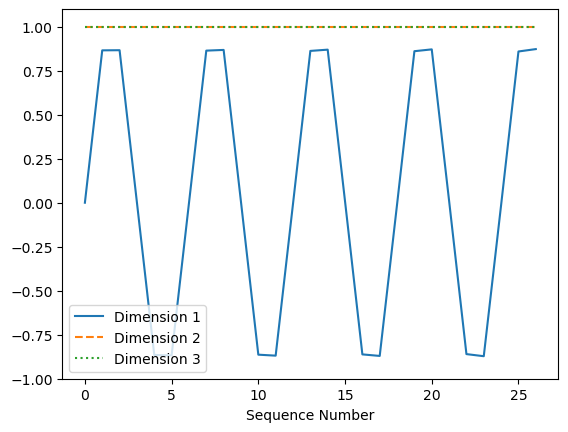

In [27]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

By incorporating sine and cosine functions with varying frequencies, you can effectively encode sequences of differing lengths. As demonstrated here, it becomes evident that these encodings position elements in such a way that they maintain proximity while still preserving their distinctiveness from one another.


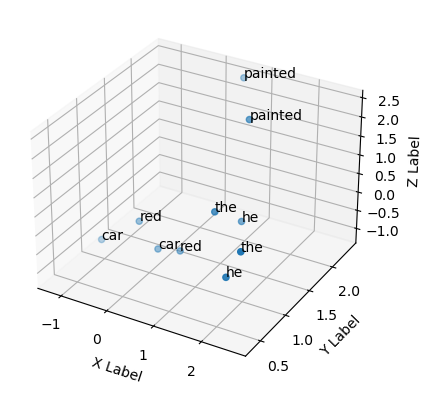

In [28]:
pe=torch.cat((torch.cos(2*3.14*position/25), torch.sin(2*3.14*position/25),  torch.sin(2*3.14*position/5)), 1)
pos_embding=my_embdings+pe[0:samples,:].numpy()
plot_embdings(pos_embding,tokenizer(my_tokens),vocab)

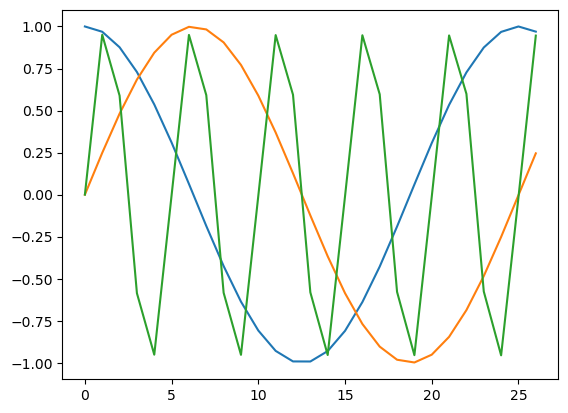

In [29]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

Overall, periodic functions provide a more expressive and adaptable means of encoding positional information in sequences, making them a preferred choice in modern sequence-to-sequence models like transformers. They offer improved capabilities for modeling both short-range and long-range dependencies, which are crucial for tasks in natural language processing and other domains. You can use the following class to apply Positional Encoding. The dropout probability is applied to the positional encodings to prevent overfitting.


In [30]:
from torch import nn

class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

## Encoder layer


### What is self-attention?

Each word (or token) in a sentence is compared to every other word, including itself, to determine how much attention or importance should be assigned to each word. Three set of vectors - query, key and value are created for the tokens. Let's have a look at an analogy which will paint a better picture for these vectors.

- Query: When you enter a search query into a search engine like Google, the text you enter in the search bar serves as the query. For example, if you search for "best smartphones," this is your query.
- Key: The search engine has indexed and stored information from web pages all over the internet. Each web page contains a variety of textual information, including titles, headings, content, and metadata. All of this text serves as the keys. In the context of your query, the keys could include words and phrases found in web page titles, headers, and content.
- Value: When you submit your query, the search engine's algorithms use the query to find the most relevant web pages from its database. These web pages are the values. The search engine returns a list of web pages (search results) that are considered the best matches for your query based on their content and relevance to the keys associated with your query.


### nn.TransformerEncoderLayer

The Transformer Encoder Layer is a specialized network layer commonly used for processing sequential data. Unlike a standard linear layer, it incorporates a unique set of parameters designed to capture intricate relationships between data samples. In your implementation, you can utilize `nn.TransformerEncoderLayer`. Consider the sequence of embeddings:


In [31]:
my_embdings=embedding(torch.tensor(my_index))
my_embdings

tensor([[ 1.3369,  0.3578,  0.2219],
        [ 0.4808,  1.3822,  1.4783],
        [ 1.7446, -0.1170,  0.3856],
        [-0.5995,  0.3724, -0.1912],
        [ 0.0526,  0.2343,  0.2692],
        [ 1.3369,  0.3578,  0.2219],
        [ 0.4808,  1.3822,  1.4783],
        [ 1.7446, -0.1170,  0.3856],
        [ 0.0526,  0.2343,  0.2692],
        [-0.5995,  0.3724, -0.1912]], grad_fn=<EmbeddingBackward0>)

There are ten embeddings, each with three dimensions.


In [32]:
my_embdings.shape

torch.Size([10, 3])

This line of code initializes a Transformer Encoder Layer in PyTorch using the nn.TransformerEncoderLayer class. Let's break down its components:

- `d_model=3`: This parameter specifies the dimensionality of the model's input and output features. In this case, each input and output vector will have a size of 3. You can think of this as the "width" of the model.

- `nhead=1`: It defines the number of attention heads in the multi-head self-attention mechanism. In this case, there is only one attention head, meaning that the model will perform single-head self-attention. In the context of transformers, "n heads" refer to the number of parallel attention mechanisms used to capture diverse patterns and dependencies in the data simultaneously.

- `dim_feedforward=1`: This parameter sets the dimensionality of the feedforward neural network used within the Transformer layer. The feedforward network is responsible for processing the attention output. Here, it has an extremely low dimension of 1, which is unusually small and may not perform well in practice. In practice, this value is typically much larger to capture complex patterns.

- `dropout=0`: Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to zero during training. A dropout rate of 0 means no dropout will be applied in this layer.


In [33]:
encoder_layer=nn.TransformerEncoderLayer(
            d_model=3,
            nhead=1,
            dim_feedforward=1,
            dropout=0,
        )

In the context of transformers, your objective is to train the model to take an input sequence and effectively generate another sequence as its output, a fundamental task that underlies a wide range of natural language processing and sequence-to-sequence tasks.


In [34]:
out=encoder_layer(my_embdings)
out

tensor([[ 1.1306,  0.1704, -1.3010],
        [-0.7776,  1.4118, -0.6342],
        [ 1.3067, -0.1851, -1.1217],
        [-0.1839,  1.3063, -1.1224],
        [-0.1023,  1.2727, -1.1704],
        [ 1.1306,  0.1704, -1.3010],
        [-0.7776,  1.4118, -0.6342],
        [ 1.3067, -0.1851, -1.1217],
        [-0.1023,  1.2727, -1.1704],
        [-0.1839,  1.3063, -1.1224]], grad_fn=<NativeLayerNormBackward0>)

In the context of transformers, for tasks such as sequence classification, you aggregate these individual outputs, often by calculating their mean, resulting in a single activation value. Subsequently, standard neural network layers are employed to perform the final sequence classification.


In [35]:
out.mean(dim=1)

tensor([-3.9736e-08,  3.9736e-08,  0.0000e+00,  0.0000e+00, -7.9473e-08,
        -3.9736e-08,  3.9736e-08,  0.0000e+00, -7.9473e-08,  0.0000e+00],
       grad_fn=<MeanBackward1>)

You can access the parameters of the transformer, which encompass several crucial components. Among these, the key, query, and value parameters are particularly significant, playing pivotal roles in the model's attention mechanism and overall functionality.


In [36]:
params_dict = encoder_layer.state_dict()
# Print the parameter names and shapes
for name, param in params_dict.items():
    print(name, param.shape)

self_attn.in_proj_weight torch.Size([9, 3])
self_attn.in_proj_bias torch.Size([9])
self_attn.out_proj.weight torch.Size([3, 3])
self_attn.out_proj.bias torch.Size([3])
linear1.weight torch.Size([1, 3])
linear1.bias torch.Size([1])
linear2.weight torch.Size([3, 1])
linear2.bias torch.Size([3])
norm1.weight torch.Size([3])
norm1.bias torch.Size([3])
norm2.weight torch.Size([3])
norm2.bias torch.Size([3])


The key, query, and value parameters are shown here.


In [37]:
embed_dim=3
q_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][0:embed_dim].t()
k_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
v_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

## Query, key, and value 

In the context of self-attention in a transformer, you can perform the following projections:

**Query (Q)**: $Q = XW^Q$

**Key (K)**: $K = XW^K$

**Value (V)**: $V = XW^V$

Here, $X$ represents the embeddings and $W$ represents learnable weights.


In [38]:
Q=my_embdings@q_proj_weight
K=my_embdings@k_proj_weight
V=my_embdings@v_proj_weight

Attention scores:
$
   \text{Scores} = \frac{QK^T}{\sqrt{d_k}}
$


In [39]:
scores=Q@K.T/np. sqrt(embed_dim)
scores

tensor([[-5.1652e-01, -5.8888e-01, -4.1276e-01, -7.2042e-03, -8.9689e-02,
         -5.1652e-01, -5.8888e-01, -4.1276e-01, -8.9689e-02, -7.2042e-03],
        [-1.0187e+00, -9.1677e-01, -8.8424e-01,  4.9609e-02, -1.3305e-01,
         -1.0187e+00, -9.1677e-01, -8.8424e-01, -1.3305e-01,  4.9609e-02],
        [-4.2788e-01, -4.7926e-01, -3.3176e-01, -1.5322e-02, -7.2512e-02,
         -4.2788e-01, -4.7926e-01, -3.3176e-01, -7.2512e-02, -1.5322e-02],
        [ 7.7904e-03,  3.8211e-04, -2.9254e-03,  8.5328e-03, -3.9999e-04,
          7.7904e-03,  3.8211e-04, -2.9254e-03, -3.9999e-04,  8.5328e-03],
        [-1.6945e-01, -1.4779e-01, -1.4818e-01,  9.2492e-03, -2.1284e-02,
         -1.6945e-01, -1.4779e-01, -1.4818e-01, -2.1284e-02,  9.2492e-03],
        [-5.1652e-01, -5.8888e-01, -4.1276e-01, -7.2042e-03, -8.9689e-02,
         -5.1652e-01, -5.8888e-01, -4.1276e-01, -8.9689e-02, -7.2042e-03],
        [-1.0187e+00, -9.1677e-01, -8.8424e-01,  4.9609e-02, -1.3305e-01,
         -1.0187e+00, -9.1677e-0

You can calculate the attention weights using the softmax function applied to the Scores and then multiply them by the values:

$O = \text{softmax}(\text{Scores})\cdot V$


In [40]:
head=nn.Softmax(dim=1)(scores)@V
head

tensor([[0.2180, 0.2292, 0.5749],
        [0.2196, 0.1926, 0.4511],
        [0.2207, 0.2383, 0.6024],
        [0.2371, 0.2759, 0.7120],
        [0.2341, 0.2629, 0.6711],
        [0.2180, 0.2292, 0.5749],
        [0.2196, 0.1926, 0.4511],
        [0.2207, 0.2383, 0.6024],
        [0.2341, 0.2629, 0.6711],
        [0.2371, 0.2759, 0.7120]], grad_fn=<MmBackward0>)

In the context of multi-head attention, you can partition the embedding dimension into $h$ subspaces, each with a dimension of $d/h$, and independently apply the attention mechanism to these smaller components. Following the attention operation, you can collect the outputs and continue with the subsequent matrix operations.


## Attention weights and linear transformation

### Softmax attention weights

After calculating the attention scores, you can proceed with linear transformations as follows:

1. **Concatenated output**: You can concatenate the individual output vectors as follows:

   $$
   O_{\text{concat}} = [O_1, O_2, \ldots, O_h]
   $$

2. **Final output**: The final output is obtained by applying a linear transformation to the concatenated output:

   $$
   O_{\text{final}} = O_{\text{concat}}W^O + b^O
   $$

Here, $W^O$ represents the weight matrix, and $b^O$ represents the bias vector for the linear transformation.


These equations depict the fundamental elements of multi-head self-attention in a transformer. While there are several additional considerations, these pertain more to optimizing training and are akin to common practices in standard neural networks.

### Multiple attention layers:
Similar to deep neural networks that can have multiple hidden layers, transformers can also be configured with multiple attention layers.

**`nn.TransformerEncoder`** is a module that represents a stack of multiple transformer encoder layers. Let's break down the parameters you've provided:

**encoder_layer**: This parameter specifies the type of transformer encoder layer that you want to use within the stack. In your case, you've defined an encoder layer using `nn.TransformerEncoderLayer` with specific configurations. The encoder_layer will be repeated multiple times in the stack.

**num_layers=2**: This parameter indicates the number of encoder layers to stack on top of each other within the `nn.TransformerEncoder`. In your example, you've chosen to stack 2 encoder layers.


In [41]:
transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2)

You can display the other layer.


In [42]:
params_dict = transformer_encoder.state_dict()
for name, param in params_dict.items():
    print(name, param.shape)

layers.0.self_attn.in_proj_weight torch.Size([9, 3])
layers.0.self_attn.in_proj_bias torch.Size([9])
layers.0.self_attn.out_proj.weight torch.Size([3, 3])
layers.0.self_attn.out_proj.bias torch.Size([3])
layers.0.linear1.weight torch.Size([1, 3])
layers.0.linear1.bias torch.Size([1])
layers.0.linear2.weight torch.Size([3, 1])
layers.0.linear2.bias torch.Size([3])
layers.0.norm1.weight torch.Size([3])
layers.0.norm1.bias torch.Size([3])
layers.0.norm2.weight torch.Size([3])
layers.0.norm2.bias torch.Size([3])
layers.1.self_attn.in_proj_weight torch.Size([9, 3])
layers.1.self_attn.in_proj_bias torch.Size([9])
layers.1.self_attn.out_proj.weight torch.Size([3, 3])
layers.1.self_attn.out_proj.bias torch.Size([3])
layers.1.linear1.weight torch.Size([1, 3])
layers.1.linear1.bias torch.Size([1])
layers.1.linear2.weight torch.Size([3, 1])
layers.1.linear2.bias torch.Size([3])
layers.1.norm1.weight torch.Size([3])
layers.1.norm1.bias torch.Size([3])
layers.1.norm2.weight torch.Size([3])
layers.1

---


## Text classification
Let's build a text classification model using PyTorch and torchtext to classify news articles into one of the four categories: World, Sports, Business, and Sci/Tech.


### Import bank dataset

Load the AG_NEWS dataset for the train split and split it into input text and corresponding labels:


In [43]:
train_iter= AG_NEWS(split="train")

The AG_NEWS dataset in torchtext does not support direct indexing like a list or tuple. It is not a random access dataset but rather an iterable dataset that needs to be used with an iterator. This approach is more effective for text data.


In [44]:
y,text= next(iter(train_iter ))
print(y,text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


You can find the label of the sample.


In [45]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

You can also use the dataset to find all the classes.


In [46]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class

4

You can build the vocabulary as before, just using the AG dataset to obtain token indices


In [47]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Here are some token indices:


In [48]:
vocab(["age","hello"])

[2120, 12544]

### Dataset


You can convert the dataset into map-style datasets and then perform a random split to create separate training and validation datasets. The training dataset will contain 95% of the samples, while the validation dataset will contain the remaining 5%. These datasets can be used for training and evaluating a machine learning model for text classification on the AG_NEWS dataset.


In [49]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

The code checks if a CUDA-compatible GPU is available in the system using PyTorch, a popular deep learning framework. If a GPU is available, it assigns the device variable to "cuda" (which stands for CUDA, the parallel computing platform and application programming interface model developed by NVIDIA). If a GPU is not available, it assigns the device variable to "cpu" (which means the code will run on the CPU instead).


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader


In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `label_pipeline` and `text_pipeline` functions to preprocess the labels and texts, respectively. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (e.g., GPU) for efficient computation.


In [51]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

You can convert the dataset objects to a data loader by applying the collate function.


In [52]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

You can see the output sequence when you have the label, text, and offsets for each batch.


In [53]:
label,seqence=next(iter(valid_dataloader ))

### Neural network


You have created a neural network for a text classification model using an `EmbeddingBag` layer, followed by a softmax output layer. Additionally, you have initialized the model using a specific method.


In [54]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        
        self,
        vocab_size,
        num_class,
        embedding_dim=100,
        nhead=5,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        self.emb = nn.Embedding(vocab_size,embedding_dim)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [55]:
y,x=next(iter(train_dataloader))

In [56]:
x

tensor([[  51,    1,    9,  ...,    0,    0,    0],
        [  45, 1652,    7,  ...,    0,    0,    0],
        [ 332,  675, 1282,  ...,    0,    0,    0],
        ...,
        [7031,    8,  510,  ...,    0,    0,    0],
        [ 118, 1955, 1755,  ...,    0,    0,    0],
        [1529, 2174,    4,  ...,    0,    0,    0]])

You have created the model, and the embedding dimension size is a free parameter.


In [57]:
emsize=64

You need the vocabulary size to determine the number of embeddings.


In [58]:
vocab_size=len(vocab)
vocab_size

95811

You have also determined the number of classes for the output layer.


In [59]:
num_class

4

Creating the model:


In [60]:
model = Net(vocab_size=vocab_size,num_class=4).to(device)
model

Net(
  (emb): Embedding(95811, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True

The code line `predicted_label=model(text, offsets)` is used to obtain predicted labels from a machine learning model for a given input text and its corresponding offsets. The `model` is the machine learning model being used for text classification or similar tasks.


In [61]:
predicted_label=model(x)

You can verify the output shape of your model. In this case, the model is trained with a mini-batch size of 64 samples. The output layer of the model produces 4 logits for each neuron, corresponding to the four classes in the classification task. You can also create a function to find the accuracy given a dataset.


In [62]:
predicted_label.shape

torch.Size([64, 4])

In [63]:
x.shape

torch.Size([64, 75])

Function **`predict`** takes in a text and a text pipeline, which preprocesses the text for machine learning. It uses a pre-trained model to predict the label of the text for text classification on the AG_NEWS dataset. The function returns the predicted label as a result.


In [64]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

In [65]:
predict("I like sports and stuff",text_pipeline )

'Business'

You can create a function to evaluate the model's accuracy on a dataset.


In [66]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

You proceed to evaluate the model, and upon observation, found that its performance is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


In [67]:
evaluate(test_dataloader, model)

0.2438157894736842

Let's train your model.


---


## Training

You set the learning rate (LR) to 0.1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multi-class classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.

**Note: The training takes a lot of time with CPU. The Skills Network lab environment provides only CPU. If you have access to GPU, you can uncomment the code below and run it to train the model. Else you can directly jump to the next section where you have been provided with a trained model and saved it for you to explore it.**


In [68]:
# LR=0.1

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

Training the model for 10 epochs.

>Please skip this step if you don't have GPU. Retrieve and use the model has been trained for 100 epochs and saved, in the next step.


In [69]:
# EPOCHS = 10
# cum_loss_list=[]
# acc_epoch=[]
# acc_old=0

# for epoch in tqdm(range(1, EPOCHS + 1)):
#     model.train()
#     cum_loss=0
#     for idx, (label, text) in enumerate(train_dataloader):
#         optimizer.zero_grad()
#         label, text=label.to(device), text.to(device)


#         predicted_label = model(text)
#         loss = criterion(predicted_label, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#         optimizer.step()
#         cum_loss+=loss.item()
#     print("Loss",cum_loss)

#     cum_loss_list.append(cum_loss)
#     accu_val = evaluate(valid_dataloader)
#     acc_epoch.append(accu_val)

#     if accu_val > acc_old:
#       acc_old= accu_val
#       torch.save(model.state_dict(), 'my_model.pth')

# save_list_to_file(lst=cum_loss_list, filename="loss.pkl")
# save_list_to_file(lst=acc_epoch, filename="acc.pkl")

You have the capability to upload the trained model along with comprehensive data on cumulative loss and average accuracy at each epoch.


In [70]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/my_model.pth
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/acc.pkl
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/loss.pkl

--2024-12-02 20:24:45--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/my_model.pth
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87539407 (83M) [binary/octet-stream]
Saving to: ‘my_model.pth’

my_model.pth        100%[===================>]  83.48M  54.9MB/s    in 1.5s    

2024-12-02 20:24:48 (54.9 MB/s) - ‘my_model.pth’ saved [87539407/87539407]

--2024-12-02 20:24:50--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/acc.pkl
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)..

In [71]:
cum_loss_list=load_list_from_file("loss.pkl")
acc_epoch=load_list_from_file("acc.pkl")

In [72]:
pretrained_model_path = 'my_model.pth'
model_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_.load_state_dict(torch.load(pretrained_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

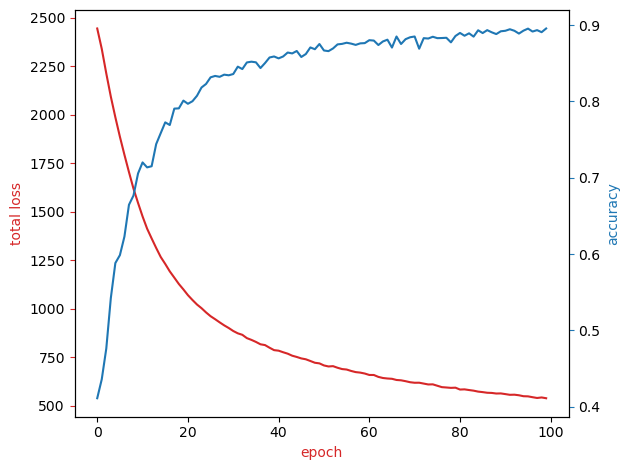

In [73]:
plot(cum_loss_list,acc_epoch)

You can evaluate the results on the test data; you achieve over 80%.


In [74]:
evaluate(test_dataloader, model_)

0.8838157894736842

The `plot_tras` function takes input words and a transformer model as arguments. It tokenizes the input words, applies the model's embedding and positional encoding layers, and extracts projection weights for query, key, and value from the model's state_dict. Using dot-product attention, it computes and visualizes attention scores as a heatmap. The softmax of these scores is also visualized as a separate heatmap. The function calculates the attention head by multiplying softmax scores with values and employs t-SNE to visualize both the embeddings and attention heads, offering insights into the attention mechanisms within the transformer model.


Rescuing an Old Saver If you think you may need to help your elderly relatives with their finances, don't be shy about having the money talk -- soon.


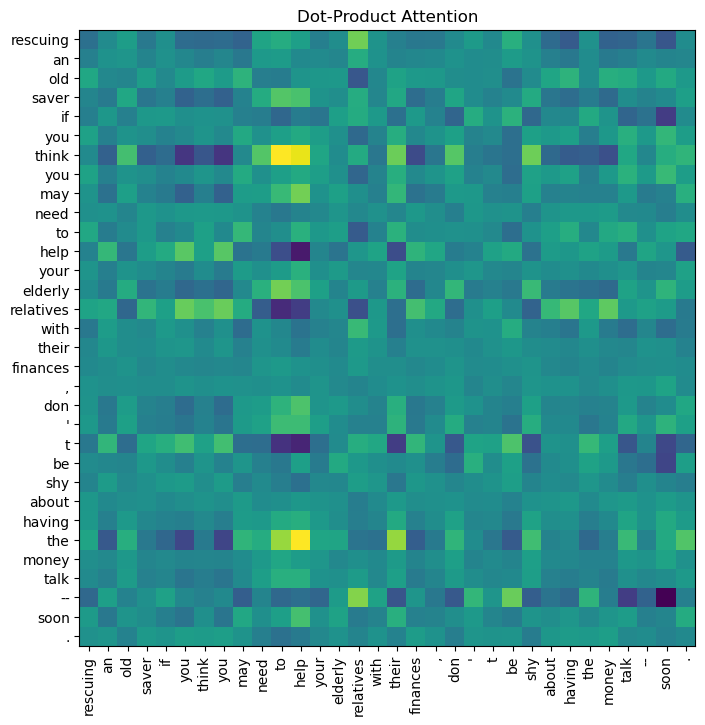

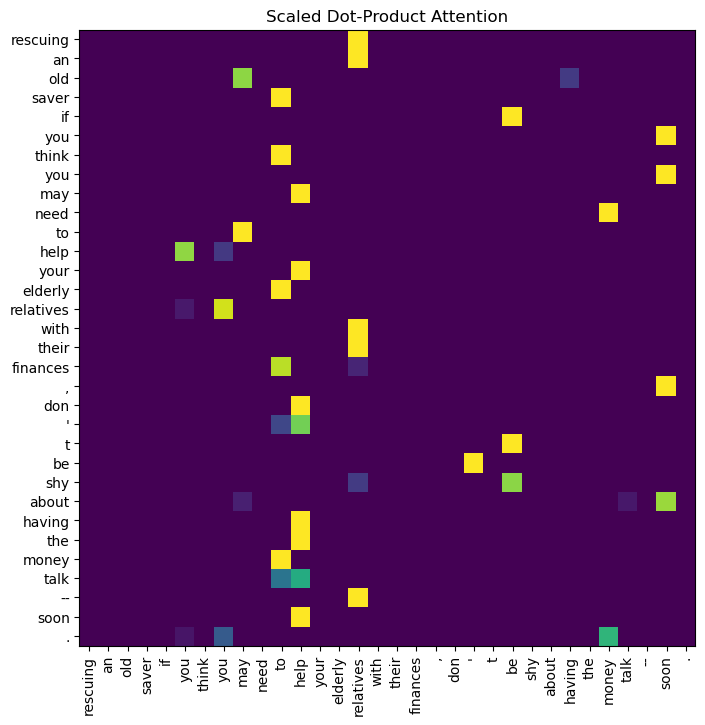

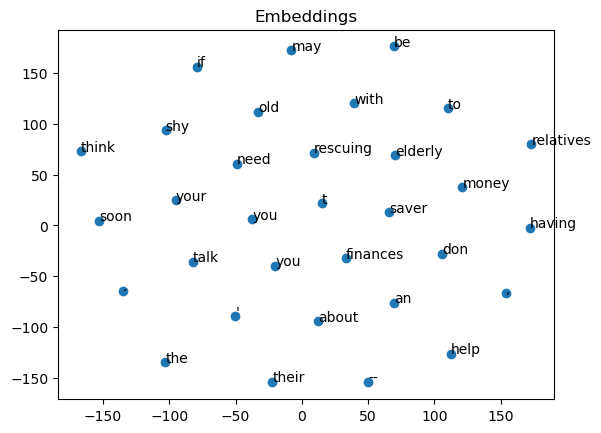

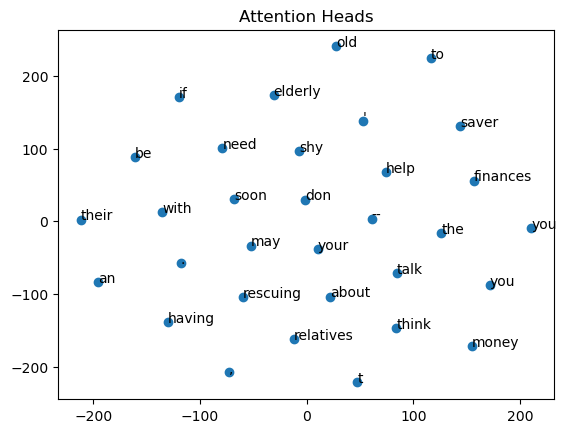

In [75]:
sample=15

words=train_dataset[sample][1]
print(words)
plot_tras(words, model)

In scaled dot-product attention, if you look from x-axis, rescuing is important with words like soon, don, their, help and an.


Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.


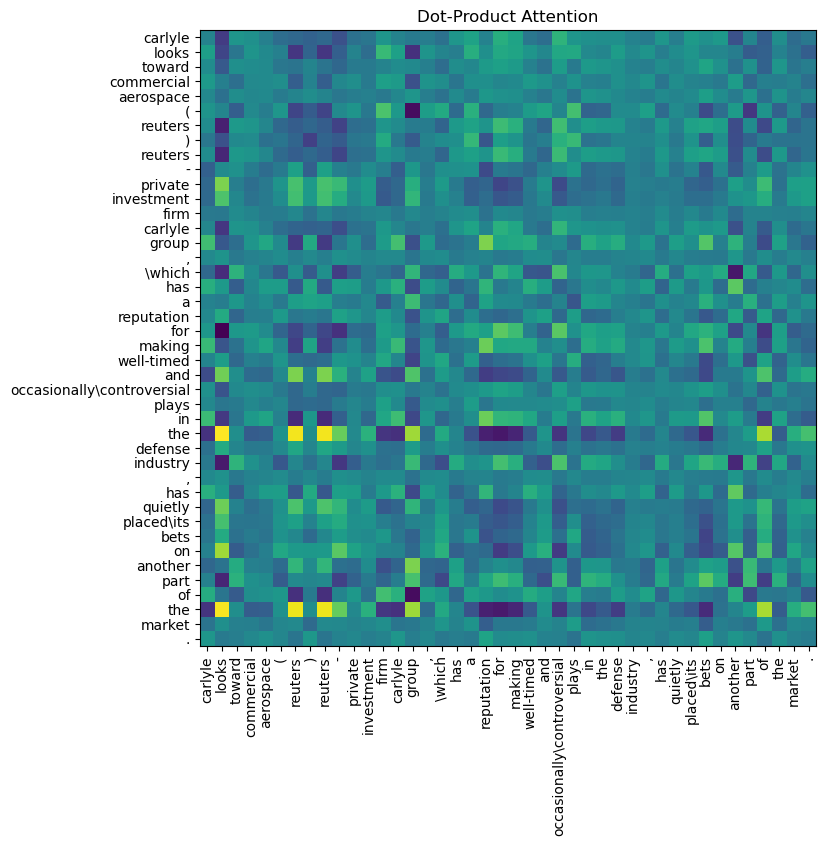

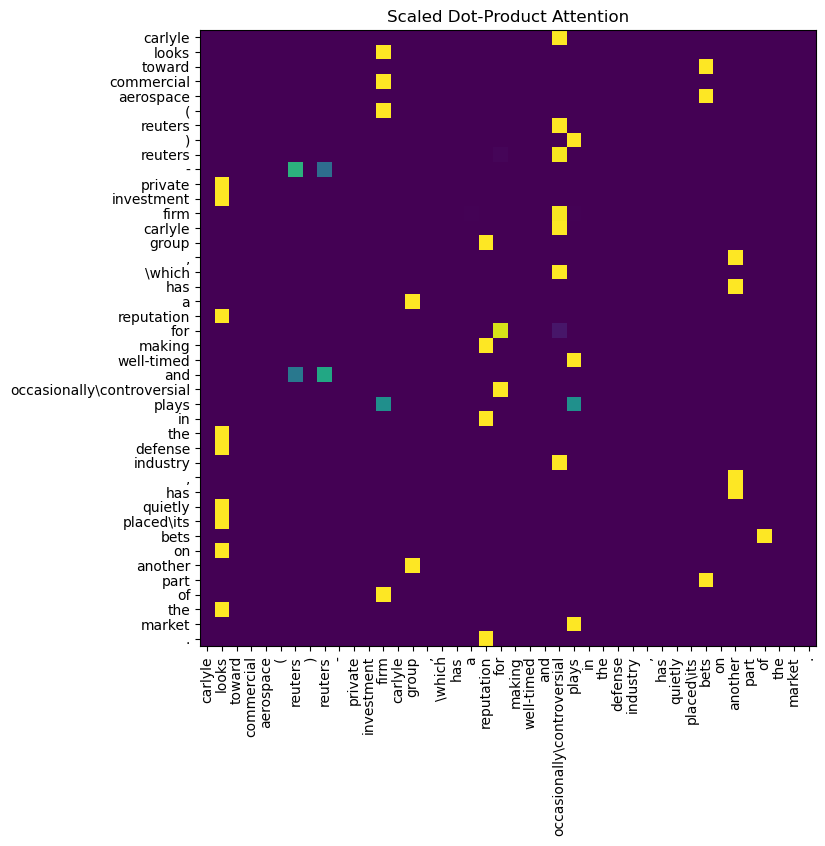

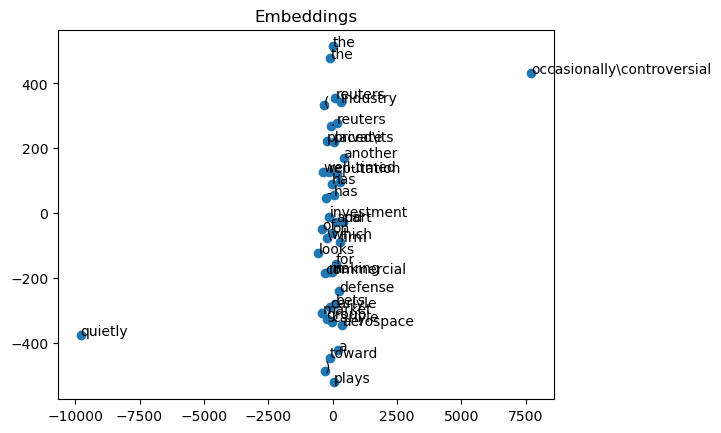

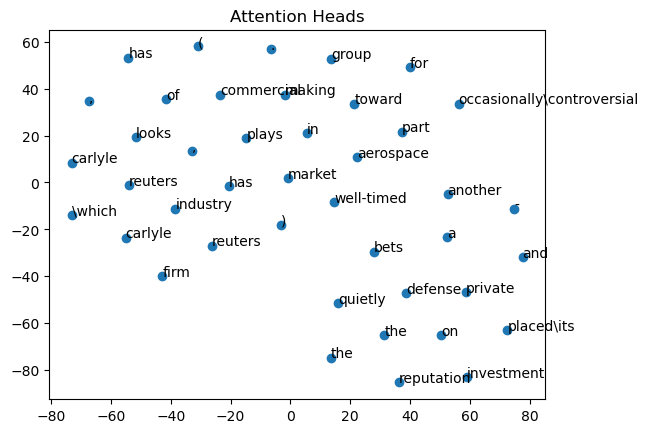

In [76]:
sample=1

words=train_dataset[sample][1]
print(words)
plot_tras(words, model)

# Exercise


You can make a prediction on the following article using the function **`predict`**.


In [77]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

This markdown content generates a styled box with light gray background and padding. It contains an `<h3>` header displaying the content of the `article` variable, and an `<h4>` header indicating the predicted category of the news article which is provided by the `result` variable. The placeholders `{article}` and `{result}` will be dynamically replaced with actual values when this markdown is rendered.


In [78]:
result = predict(article, text_pipeline) # Call predict() for the article to see the result

markdown_content = f'''
<div style="background-color: gray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: gray; padding: 10px;">
    <h3>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</h3>
    <h4>The category of the news article: Business</h4>
</div>


<details>
    <summary>Click here for Solution</summary>

```python
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: gray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)
```

</details>


Looks good!


---


## Congratulations! You have completed the lab


## Authors


[Roodra Kanwar](https://www.linkedin.com/in/roodrakanwar/) is completing his MS in CS specializing in big data from Simon Fraser University. He has previous experience working with machine learning and as a data engineer.


## Contributors


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo)

Joseph has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS from Dalhousie University. He has previous experience working with Natural Language Processing and as a Data Scientist.


## References


[TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)


© Copyright IBM Corporation. All rights reserved.
